In [1]:
import foam_ct_phantom 
import numpy as np
from pathlib import Path
from noise2inverse import tiffs, noise, tomo, fig
import tomosipo as ts
import tomopy
import tifffile

In [2]:
num_splits = 4


input_clean_dir = "projections_clean"
input_noisy_dir = "projections_noisy"
output_dir = Path("reconstructions")
output_clean_dir = output_dir / "clean"
output_noisy_dir = output_dir / "noisy"

output_dir.mkdir(exist_ok=True)
output_clean_dir.mkdir(exist_ok=True)
output_noisy_dir.mkdir(exist_ok=True)


In [3]:
# Load data
sino_clean = tiffs.load_sino(tiffs.glob(input_clean_dir))
sino_noisy = tiffs.load_sino(tiffs.glob(input_noisy_dir))

1024it [00:00, 1508.71it/s]
1024it [00:00, 1532.20it/s]


In [4]:
# Determine geometry
height, num_angles, width = sino_clean.shape

vol_shape = (height, width * 2 // 3, width * 2 // 3)
det_shape = (height, width)
angles = np.linspace(0, np.pi, num=num_angles, endpoint=False)
vg = ts.volume(size=vol_shape, pos=0, shape=vol_shape)
pg = ts.parallel(angles=angles, size=det_shape, shape=det_shape)
A = ts.operator(vg, pg)

In [7]:
# Reconstruct clean 
rec = tomo.fbp(A, sino_clean)
rec = tomopy.circ_mask(rec, axis=0, ratio=1.0)

tiffs.save_stack(output_clean_dir, rec)

512it [00:00, 540.71it/s]


In [8]:
# Reconstruct noisy
rec = tomo.fbp(A, sino_noisy)
rec = tomopy.circ_mask(rec, axis=0, ratio=1.0)
tiffs.save_stack(output_noisy_dir, rec)

512it [00:00, 543.41it/s]


In [9]:
# Reconstruct noisy splits

for j in range(num_splits):
    pg_split = pg[j::num_splits]
    sino_split = sino_noisy[:, j::num_splits, :]
    A_split = ts.operator(vg, pg_split)
    
    output_split_dir = output_dir / str(j)
    output_split_dir.mkdir(exist_ok=True)
    
    rec = tomo.fbp(A_split, sino_split)
    rec = tomopy.circ_mask(rec, axis=0, ratio=1.0)
    tiffs.save_stack(output_split_dir, rec)

512it [00:00, 527.55it/s]
512it [00:00, 523.51it/s]
512it [00:00, 533.44it/s]
512it [00:00, 513.05it/s]


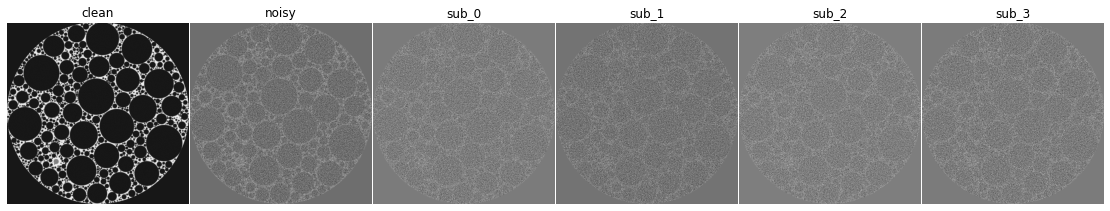

In [10]:
# Show results
slice_clean = tifffile.imread(str(output_clean_dir / "output_00256.tif"))
slice_noisy = tifffile.imread(str(output_noisy_dir / "output_00256.tif"))
slice_0 = tifffile.imread(str(output_dir / "0" / "output_00256.tif"))
slice_1 = tifffile.imread(str(output_dir / "1" / "output_00256.tif"))
slice_2 = tifffile.imread(str(output_dir / "2" / "output_00256.tif"))
slice_3 = tifffile.imread(str(output_dir / "3" / "output_00256.tif"))

fig.plot_imgs(
    clean=slice_clean,
    noisy=slice_noisy,
    sub_0=slice_0,
    sub_1=slice_1,
    sub_2=slice_2,
    sub_3=slice_3, 
    width=20.0,
)